# Skew-T - ln P plot

Demonstrate how to construct dry adiabats and isotherms for
a thermodynamic diagram using the functions in
[makeSkew.py](https://github.com/phaustin/A405/blob/master/a405skewT/makeSkew.py)

In [1]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
import matplotlib.pyplot as plt
from scipy import optimize # for rootfinding

### setting labels and ticks

The next box shows how to set up a plot of a 5 degree isotherm in
unskewed coordinates.   Not that I invert the yaxis so pressure increases
downwards, and I make y a log scale and draw a horizontal grid.

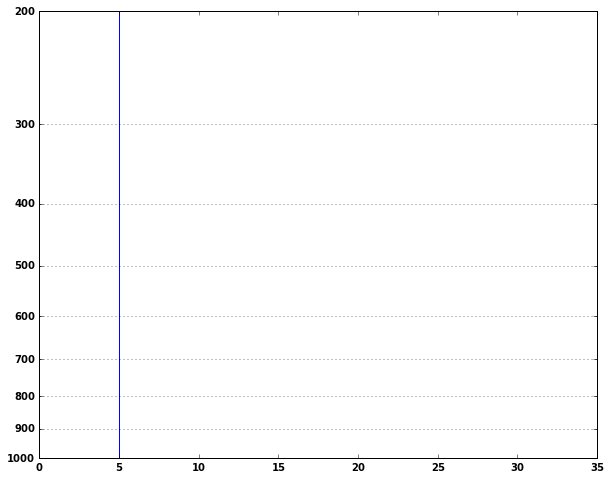

In [2]:
%matplotlib inline
press=np.linspace(200,1000,30)
temps=np.ones_like(press)*5
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(temps,press)
ax.set(xlim=[0,35])
ax.invert_yaxis()
ax.set_yscale('log')
locs = np.array(range(100, 1100, 100))
labels = locs
ax.set_yticks(locs)
ax.set_yticklabels(labels) # hand label the pressures
ax.set_ybound((200, 1000))
plt.setp(ax.get_xticklabels(), weight='bold')
plt.setp(ax.get_yticklabels(), weight='bold')
ax.yaxis.grid(True)


### Skewed temperature coordinates

If you try plotting your soundings on the conventional plot above, you'll see
that the height-temperature dependence makes it difficult to see the temperature
and dewpoint together.  The traditional approach is to slant the temperature
line by a constant slope (note that this is different from rotating the line,
because the y axis doesn't change)

In [3]:
def convertSkewToTemp(xcoord, press, skew):
    """
    convertSkewToTemp(xcoord, press, skew)

    Determines temperature from knowledge of a plotting coordinate
    system and corresponding plot skew.
    
    Parameters
    - - - - - -
    xcoord : int
        X coordinate in temperature plotting coordinates.
    press : float
        Pressure (hPa).
    skew : int
        Skew of a given coordinate system.

    Returns
    - - - -
    Temp : float
        Converted temperature in degC.

    Examples
    - - - - -
    >>> convertSkewToTemp(300, 8.e4, 30)
    638.6934574096806
    
    """
    Temp = xcoord  + skew * np.log(press);
    return Temp

def convertTempToSkew(Temp, press, skew):
    """
    convertTempToSkew(Temp, press, skew)

    Determines the transformed temperature in plotting coordinates.
    
    Parameters
    - - - - - -
    Temp : float
        Temperature (degC)
    press : float
        Pressure (hPa).
    skew : int
        Designated skew factor of temperature.

    Returns
    - - - -
    tempOut : float
        Converted temperature (degC).

    Examples
    - - - - -
    >>> convertTempToSkew(30., 8.e4, 30)
    -308.69345740968055
    
    """
    
    tempOut = Temp - skew * np.log(press);
    return tempOut


### Determining the skew

Getting a isotherm with a 45 degree slope in these coordinates is tricky, because it depends on
the shape of the plot and the exact range values chosen for the temperature and pressure axis.
Calculating the slope that will give a 45 degree angle isn't particularly hard (try it), but
it's easier to just try some different skew values, and then save the result so you can put
your data up in the same coordinates.  For square plots with typical sounding ranges setting
skew = 30 Kelvin  is about right

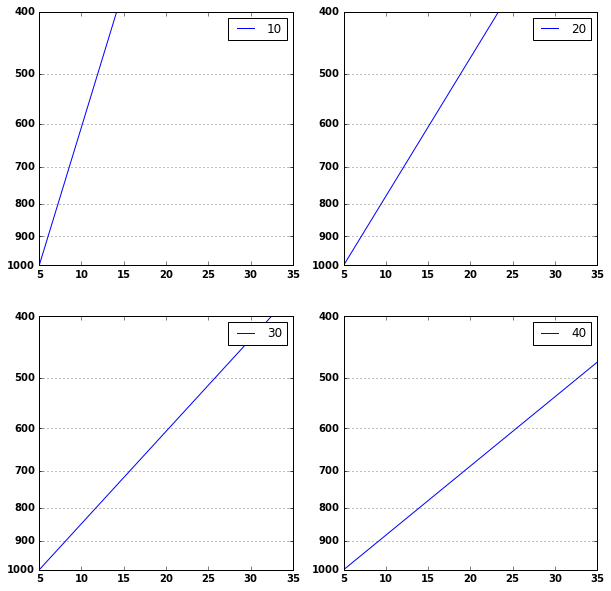

In [4]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
axes=axes.ravel()  #axes comes back as a 2x2 array, flatten it
press=np.linspace(200,1000,30)
the_temp=5.
linelist=[]
skew_vals=[10,20,30, 40]
for ax,skew in zip(axes,skew_vals):
    xcoord=convertTempToSkew(the_temp,press,skew)
    ax.plot(xcoord,press,label=skew)
    ax.invert_yaxis()
    ax.set_yscale('log')
    locs = np.array(range(100, 1100, 100))
    labels = locs
    ax.set_yticks(locs)
    ax.set_yticklabels(labels) # Conventionally labels semilog graph.
    ax.set_ybound((400, 1000))
    plt.setp(ax.get_xticklabels(), weight='bold')
    plt.setp(ax.get_yticklabels(), weight='bold')
    ax.yaxis.grid(True)
    out=ax.legend()
    TempTickLabels = range(-15, 40, 5)
    TempTickCoords = TempTickLabels
    skewTickCoords = convertTempToSkew(TempTickCoords, 1.e3, skew)
    ax.set_xticks(skewTickCoords)
    out=ax.set_xticklabels(TempTickLabels)
    skewLimits = convertTempToSkew([5, 35], 1.e3, skew)
    out=ax.set(xlim=skewLimits)

In [5]:
from a405skewT.makeSkew import makeSkewDry
import a405skewT.makeSkew
from importlib import reload
reload(a405skewT.makeSkew)

<module 'a405skewT.makeSkew' from 'C:\\Users\\Timothy\\Documents\\GitHub\\A405\\a405skewT\\makeSkew.py'>

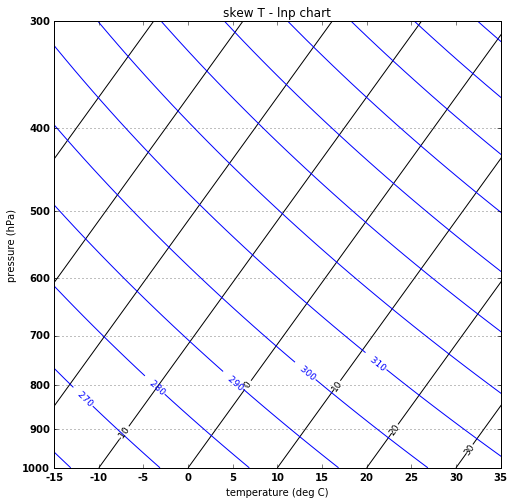

In [6]:
#%config InlineBackend.close_figures=True
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

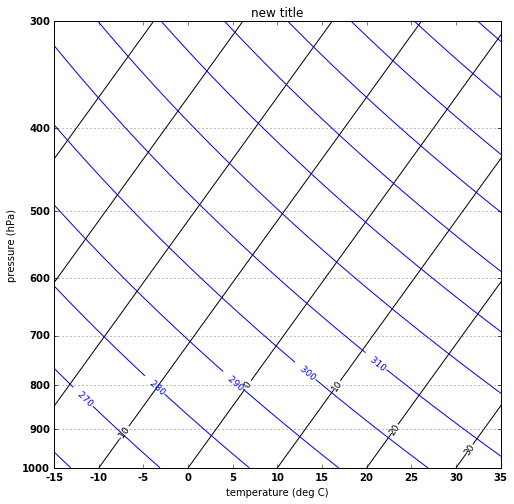

In [7]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)
ax.set(title='new title')
#plt.show()
#display(fig)

In [8]:
filename='out.h5'; # Hilo International September 2015
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[3]]
print('{0:}sounding times:{1:}{0:} '.format(separator,times))
print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]
print('variables with units: \n',pformat(units_dict))

reading file: out.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 1.0,
 'header': '91285 PHTO Hilo Observations at 00Z 01 Sep 2015',
 'history': 'written by test_requests.py',
 'latitude': 19.719999999999999,
 'longitude': -155.05000000000001,
 'query': 'http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=9&FROM=0100&TO=3012&STNM=91285',
 'site_id': '91285',
 'timestamp': '2016-01-18 18:26:12 UTC',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}

++++++++++++++++++++++++++++++
sounding times:['/Y2015_Sep_01_00Z', '/Y2015_Sep_01_06Z', '/Y2015_Sep_01_12Z', '/Y2015_Sep_01_18Z', '/Y2015_Sep_02_00Z', '/Y2015_Sep_02_06Z', '/Y2015_Sep_02_12Z', '/Y2015_Sep_03_00Z', '/Y2015_Sep_03_12Z', '/Y2015_Sep_04_00Z', '/Y2015_Sep_04_12Z', '/Y2015_Sep_05_00Z', '/Y2015_Sep_05_12Z', '/Y2015_Sep_06_00Z', '/Y2015_Sep_06_12Z', '/Y2015_Sep_07_00Z', '/Y2015_Sep_07_12Z', '/Y2015_Sep_08_00Z',

[(1000, 400)]

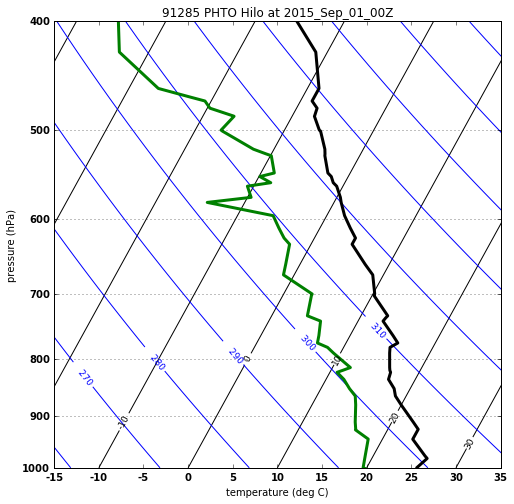

In [9]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
fig.canvas.draw()

#
#  make the last two lines added to the plot (temp and dewpoint)
#  thicker
#
[line.set(linewidth=3) for line in ax.lines[-2:]]
ax.set(title=title)
ax.set(ylim=[1000,400])
#display(fig)

In [10]:
#ax.set(ylim=[1000,700])
#display(fig)

### For Wednesday 9am

Check in a notebook that puts your sounding on the tephigram and draws a line of constant saturation mixing ratio 
$r_s$ = 10 g/kg between 1000 and  400 hPa.  

Hint -- you want to rootfind the temperature that satisfies $r_s = \frac{e_s(T)}{p - e_s(T)} = 0.01\ g/kg$
for a range of pressures then convert the temperatures to skew coordinates.

In [11]:
# rootfunctions
def root_func_es(es_guess, press, rs):
    """Rootfunction to calculate es
    
    Inputs: es_guess (Pa)
            press (Pa)
            rs (kg kg^-1)
            
    Outputs: difference between guessed rs and input rs"""
    
    return(es_guess/(press - es_guess) - rs)


def root_func_temp(temp_guess, es):
    """Rootfunction to calculate temp
    
    Inputs: temp_guess (K)
            es (Pa)
            
    Outputs: difference between guessed temp and the parameters dependent on the guessed temp"""
    
    cpv = 1870. # J kg^-1 K^-1 
    Tp = 273.16 # K
    Rv = 461.5 # J kg^-1 K^-1
    es0 = 6.11*100 # Pa
    lv0 = 2.501e6 # J kg^-1
    phi0 = lv0/Tp # J kg^-1 K^-1
    T0 = 273.15 # K
    cl = 4187. # J kg^-1 K^-1

    # Clausius-Clapeyron notes Equation 10
    RHS = -Rv*np.log(es/es0) # term without functional dependence on T
    # terms with function dependence on T (phi0 just a constant)
    LHS = ((cpv-cl)*(temp_guess - T0) + lv0)/temp_guess + cl*np.log(temp_guess/Tp) - cpv*np.log(temp_guess/Tp) - phi0
    
    # find the difference between the two
    return(LHS - RHS)
    

# main function
def calc_temp(press, rs):
    """ Rootfind temperature from constant saturation mixing ratio, at a pressure level
    
    Inputs: 
        press (hPa, float), pressure
        rs (g/kg, float), saturation mixing ratio
        
    Outputs:
        temp (K, float), temperature
        
    """
    press = press*100. # convert to Pa
    rs = rs/1000. # convert to kg kg^-1
    
    left_es = 0. # Pa
    right_es = 1000 # Pa
    
    # first rootfind es
    es = optimize.zeros.brentq(root_func_es, left_es,right_es,args=(press, rs)) # Pa
    
    left_temp = 1. # K
    right_temp = 500. # K
    
    # then plug in the found es to rootfind temp
    temp = optimize.zeros.brentq(root_func_temp, left_temp, right_temp, args=(es))
       
    return(temp)

In [12]:
press = np.array(sounding['pres']) # hPa
rs = 10. # g kg^-1

temp = []
for each_press in press:
    temp.append(calc_temp(each_press,rs))

temp = np.array(temp) - 273.15 # convert to C
xcoord_isohumeT = []

couplet = zip(temp, press) # convert to skew-T coordinates
for each_temp,each_press in couplet:
    xcoord_isohumeT.append(convertTempToSkew(each_temp,each_press,skew))

[(1000, 400)]

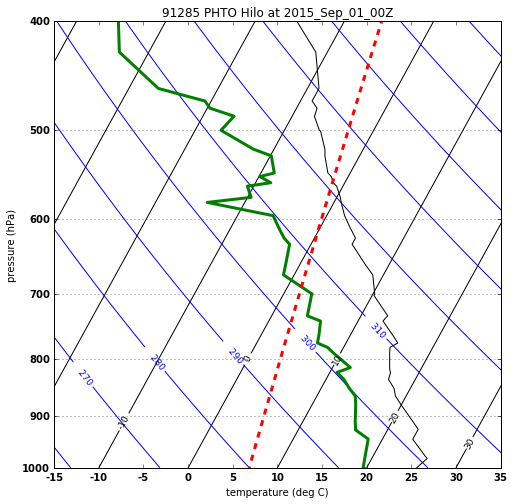

In [13]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)

triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
ax.plot(xcoord_isohumeT,press,color='r',linestyle="--",label="rs = {} g kg^-1".format(rs)) # include isohume
fig.canvas.draw()

#
#  make the last two lines added to the plot (temp and dewpoint)
#  thicker
#
[line.set(linewidth=3) for line in ax.lines[-2:]]
ax.set(title=title)
ax.set(ylim=[1000,400])